## Data Visualization

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from time import perf_counter
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers

In [ ]:
!pip install -q kaggle
!pip install -q kaggle-cli
!mkdir -p ~/.kaggle
!cp "KaggleToken/kaggle.json" ~/.kaggle/
!cat ~/.kaggle/kaggle.json 
!chmod 600 ~/.kaggle/kaggle.json

     |████████████████████████████████| 81kB 7.6MB/s 
     |████████████████████████████████| 4.2MB 12.0MB/s 
     |████████████████████████████████| 143kB 54.0MB/s 
     |████████████████████████████████| 51kB 8.3MB/s 
     |████████████████████████████████| 112kB 58.9MB/s 
  ERROR: Failed building wheel for lxml
    Running setup.py install for lxml ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-p4wmvcwp/lxml/setup.py'"'"'; __file__='"'"'/tmp/pip-install-p4wmvcwp/lxml/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-qg6aokd3/install-record.txt --single-version-externally-managed --compile Check the logs for full command output.
{"username":"jesslynmarcellina","key":"6881ff0a9a19ee105489f7a6e00f2272"}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!kaggle datasets download -d grassknoted/asl-alphabet -p KaggleDataset

 99% 1.02G/1.03G [00:17<00:00, 53.6MB/s]
100% 1.03G/1.03G [00:17<00:00, 64.0MB/s]


In [ ]:
import os
import zipfile

local_zip = '/content/KaggleDataset/asl-alphabet.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/KaggleDataset/asl-alphabet')
zip_ref.close()

In [ ]:
# Create a list with the filepaths for training and testing
dir_ = Path('/content/KaggleDataset/asl-alphabet')
file_paths = list(dir_.glob(r'asl_alphabet_train/**/*.jpg'))
print(dir_)

/content/KaggleDataset/asl-alphabet


In [ ]:
#Number of pictures and different labels in dataset
def proc_img(filepath):

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]
    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)
    
    return df

df = proc_img(file_paths)

print(f'Number of pictures in the dataset: {df.shape[0]}\n')
print(f'Number of different labels in the dataset: {len(df.Label.unique())}\n')
print(f'Labels: {df.Label.unique()}')

# The DataFrame with the filepaths in one column and the labels in the other one
df.head(5)

Number of pictures in the dataset: 87000

Number of different labels in the dataset: 29

Labels: ['N' 'Z' 'B' 'F' 'W' 'T' 'nothing' 'R' 'Y' 'O' 'C' 'J' 'D' 'X' 'G' 'I' 'V'
 'A' 'U' 'H' 'space' 'L' 'S' 'K' 'Q' 'P' 'M' 'del' 'E']


,Filepath,Label
0,/content/KaggleDataset/asl-alphabet/asl_alphab...,N
1,/content/KaggleDataset/asl-alphabet/asl_alphab...,Z
2,/content/KaggleDataset/asl-alphabet/asl_alphab...,B
3,/content/KaggleDataset/asl-alphabet/asl_alphab...,F
4,/content/KaggleDataset/asl-alphabet/asl_alphab...,W


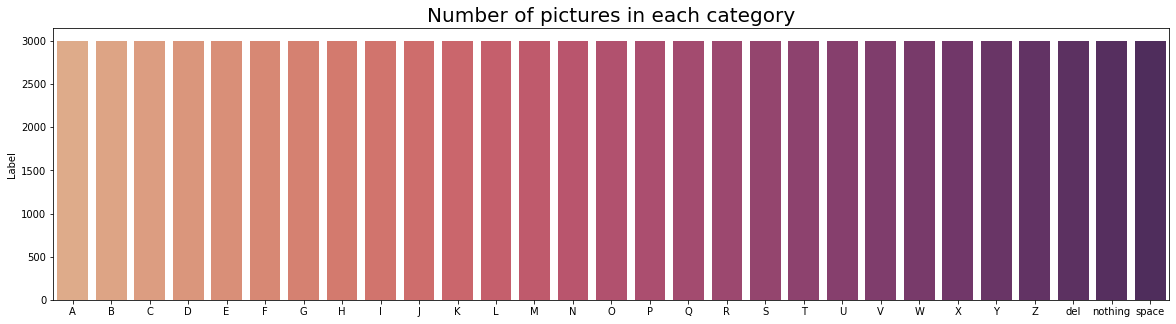

In [ ]:
#Number of pictures in each category
vc = df['Label'].value_counts()
plt.figure(figsize=(20,5))
sns.barplot(x = sorted(vc.index), y = vc, palette = "flare")
plt.title("Number of pictures in each category", fontsize = 20)
plt.show()

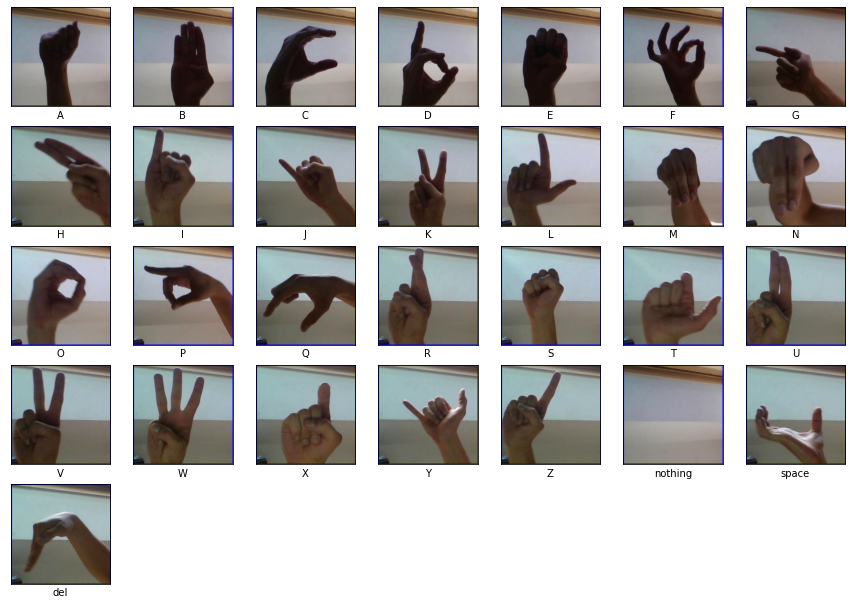

In [ ]:
#Display all pictures unique labels
train_dir = os.path.join(str(dir_),"asl_alphabet_train/asl_alphabet_train")
test_dir = os.path.join(str(dir_),"asl_alphabet_test/asl_alphabet_test")

classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 
           'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 
           'W', 'X', 'Y', 'Z', 'nothing', 'space', 'del']

plt.figure(figsize=(15, 15))

for i in range (0,29):
    plt.subplot(7,7,i+1)
    plt.xticks([])
    plt.yticks([])
    path = train_dir + "/{0}/{0}1.jpg".format(classes[i])
    img = plt.imread(path)
    plt.imshow(img)
    plt.xlabel(classes[i])

In [1]:
train_df, test_df = train_test_split(df.sample(frac = 1), test_size=0.2, random_state=42)

NameError: name 'train_test_split' is not defined

In [ ]:
def create_gen():
    # Load the Images with a generator and Data Augmentation
    train_generator = ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=45, # Uncomment to use data augmentation
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=45, # Uncomment to use data augmentation
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    
    return train_generator,test_generator,train_images,val_images,test_images

In [ ]:
def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}
    
    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False
    
    inputs = pretrained_model.input

    x = layers.Dense(128, activation='relu')(pretrained_model.output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.2)(x)  
    outputs = layers.Dense(29, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [ ]:
models = {
    "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "DenseNet169": {"model":tf.keras.applications.DenseNet169, "perf":0},
    "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
    "EfficientNetB0": {"model":tf.keras.applications.EfficientNetB0, "perf":0},
    "EfficientNetB1": {"model":tf.keras.applications.EfficientNetB1, "perf":0},
    "EfficientNetB2": {"model":tf.keras.applications.EfficientNetB2, "perf":0},
    "EfficientNetB3": {"model":tf.keras.applications.EfficientNetB3, "perf":0},
    "EfficientNetB4": {"model":tf.keras.applications.EfficientNetB4, "perf":0},
    "EfficientNetB5": {"model":tf.keras.applications.EfficientNetB4, "perf":0},
    "EfficientNetB6": {"model":tf.keras.applications.EfficientNetB4, "perf":0},
    "EfficientNetB7": {"model":tf.keras.applications.EfficientNetB4, "perf":0},
    "InceptionResNetV2": {"model":tf.keras.applications.InceptionResNetV2, "perf":0},
    "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    "MobileNet": {"model":tf.keras.applications.MobileNet, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "MobileNetV3Large": {"model":tf.keras.applications.MobileNetV3Large, "perf":0},
    "MobileNetV3Small": {"model":tf.keras.applications.MobileNetV3Small, "perf":0},
    "NASNetMobile": {"model":tf.keras.applications.NASNetMobile, "perf":0},
    "ResNet101": {"model":tf.keras.applications.ResNet101, "perf":0},
    "ResNet101V2": {"model":tf.keras.applications.ResNet101V2, "perf":0},
    "ResNet152": {"model":tf.keras.applications.ResNet152, "perf":0},
    "ResNet152V2": {"model":tf.keras.applications.ResNet152V2, "perf":0},
    "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    "ResNet50V2": {"model":tf.keras.applications.ResNet50V2, "perf":0},
    "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
    "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
    "Xception": {"model":tf.keras.applications.Xception, "perf":0}
}

# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

# Fit the models
for name, model in models.items():
    
    # Get the model
    m = get_model(model['model'])
    models[name]['model'] = m
    
    start = perf_counter()
    
    # Fit the model
    history = m.fit(train_images,validation_data=val_images,epochs=1,verbose=1)
    
    # Sav the duration and the val_accuracy
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")
    
    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]

Found 3132 validated image filenames belonging to 29 classes.
Found 348 validated image filenames belonging to 29 classes.
Found 870 validated image filenames belonging to 29 classes.


98/98 [==============================] - 45s 101ms/step - loss: 2.8901 - accuracy: 0.2021 - val_loss: 1.2133 - val_accuracy: 0.6868
DenseNet121          trained in 45.6 sec
98/98 [==============================] - 10s 77ms/step - loss: 2.6770 - accuracy: 0.2664 - val_loss: 0.7718 - val_accuracy: 0.7356
MobileNetV2          trained in 10.17 sec
98/98 [==============================] - 18s 108ms/step - loss: 2.8055 - accuracy: 0.2404 - val_loss: 1.0475 - val_accuracy: 0.7529
DenseNet169          trained in 18.24 sec
98/98 [==============================] - 22s 131ms/step - loss: 2.7397 - accuracy: 0.2416 - val_loss: 1.0131 - val_accuracy: 0.7098
DenseNet201          trained in 22.21 sec
98/98 [==============================] - 13s 86ms/step - loss: 3.3793 - accuracy: 0.0279 - val_loss: 3.3686 - val_accura

In [ ]:
# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name, models[name]['val_acc'][-1], 
                          models[name]['perf']])
    
df_results = pd.DataFrame(models_result, 
                          columns = ['model','val_accuracy','Training time (sec)'])
df_results.sort_values(by='val_accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

,model,val_accuracy,Training time (sec)
0,MobileNet,0.8764,10.12
1,ResNet101V2,0.8075,18.79
2,ResNet50V2,0.7874,10.94
3,DenseNet169,0.7529,18.24
4,ResNet152V2,0.7500,23.94
5,MobileNetV2,0.7356,10.17
6,Xception,0.7241,12.41
7,DenseNet201,0.7098,22.21
8,DenseNet121,0.6868,45.60
9,NASNetMobile,0.5891,21.88


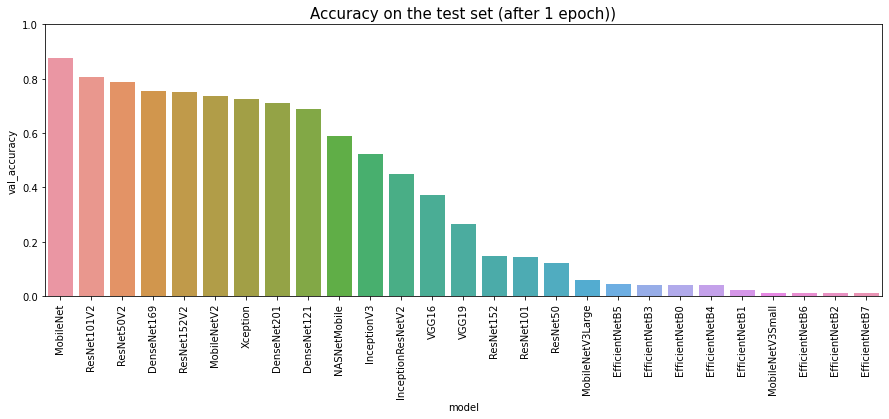

In [ ]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'val_accuracy', data = df_results)
plt.title('Accuracy on the test set (after 1 epoch))', fontsize = 15)
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()

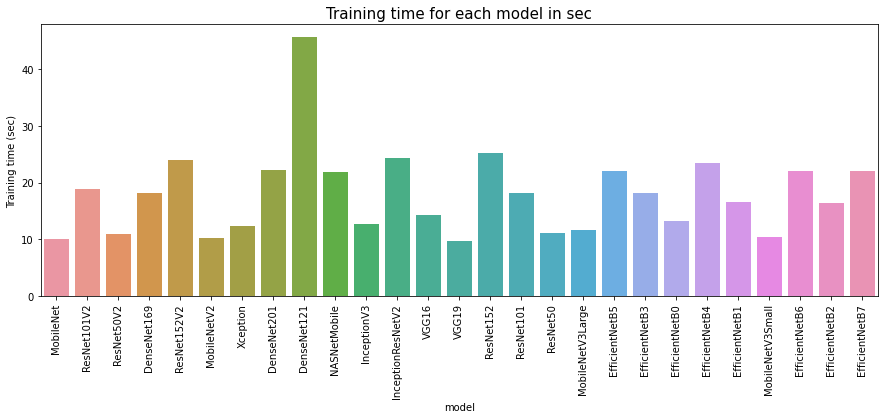

In [ ]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'Training time (sec)', data = df_results)
plt.title('Training time for each model in sec', fontsize = 15)
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Use the whole data which is split into training and test datasets
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)

# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()

# Get the model with the highest validation score
best_model = df_results.iloc[0]

# Create a new model
model = get_model( eval("tf.keras.applications."+ best_model[0]) )

# Train the model
history = model.fit(train_images,
                    validation_data=val_images,
                    epochs=5,
                    callbacks=[
                        tf.keras.callbacks.EarlyStopping(
                            monitor='val_loss',
                            patience=1,
                            restore_best_weights=True)]
                    )

Found 70470 validated image filenames belonging to 29 classes.
Found 7830 validated image filenames belonging to 29 classes.
Found 8700 validated image filenames belonging to 29 classes.
Epoch 1/5
2203/2203 [==============================] - 183s 82ms/step - loss: 0.5393 - accuracy: 0.8472 - val_loss: 0.0498 - val_accuracy: 0.9847
Epoch 2/5
2203/2203 [==============================] - 147s 67ms/step - loss: 0.0355 - accuracy: 0.9877 - val_loss: 0.0132 - val_accuracy: 0.9966
Epoch 3/5
2203/2203 [==============================] - 148s 67ms/step - loss: 0.0267 - accuracy: 0.9912 - val_loss: 0.0082 - val_accuracy: 0.9969
Epoch 4/5
2203/2203 [==============================] - 147s 67ms/step - loss: 0.0210 - accuracy: 0.9935 - val_loss: 0.0260 - val_accuracy: 0.9926


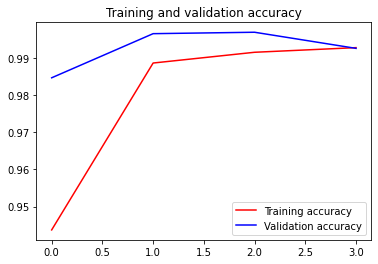

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()


INFO:tensorflow:Assets written to: /tmp/tmp65i3picy/assets


In [ ]:
#Convert to int8
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT] 
tflite_quant_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpuavmd8tj/assets


INFO:tensorflow:Assets written to: /tmp/tmpuavmd8tj/assets


In [ ]:
#Save model
import pathlib

tflite_models_dir = pathlib.Path("/content/ModelDataset")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

# Save the unquantized/float model:
tflite_model_file = tflite_models_dir/"model.tflite"
tflite_model_file.write_bytes(tflite_model)


13487900

In [ ]:
# Save the quantized model:
tflite_model_quant_file = tflite_models_dir/"model_quant_uint8.tflite"
tflite_model_quant_file.write_bytes(tflite_quant_model )

6761312

In [ ]:
#Convert to a float16 quantization
converter.target_spec.supported_types = [tf.float16]
tflite_quant_model = converter.convert()

#Save the model
tflite_fp16_model = converter.convert()
tflite_model_fp16_file = tflite_models_dir/"model_quant_f16.tflite"
tflite_model_fp16_file.write_bytes(tflite_fp16_model)

INFO:tensorflow:Assets written to: /tmp/tmphhdggq1_/assets


INFO:tensorflow:Assets written to: /tmp/tmphhdggq1_/assets


INFO:tensorflow:Assets written to: /tmp/tmp2b5m88ru/assets


INFO:tensorflow:Assets written to: /tmp/tmp2b5m88ru/assets


6761312